This notebook runs comparison between the scaling for Z and the model's depth of upwelling.

In [1]:
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import cmocean as cmo
import xarray as xr
import numpy as np
from scipy import interpolate
from salishsea_tools import gsw_calls
from salishsea_tools import nc_tools, viz_tools
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_idealized
import functions_plot
import functions_profiles
import functions_upwelling_depth

# Z Scaling

In [2]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def get_scaling_vars(initial_sal, initial_tem, bathy, sal_ref, dep_ref, nav_lat, deptht, u_vel, tmask, depth_levels, sal):
    
    dep = -1 * deptht
    lat = np.ones(1) * np.mean(nav_lat)
    p = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [dep, lat], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')


    SA = initial_sal[0,:,0,0]
    CT = initial_tem[0,:,0,0]
    rho = gsw_calls.generic_gsw_caller('gsw_rho_CT_exact.m', [SA, CT, p], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')


    d_rho0 = np.diff(rho)
    d_dep0 = np.diff(dep)
    f_rho = interpolate.interp1d(np.arange(len(d_rho0)), d_rho0, fill_value='extrapolate')
    f_dep = interpolate.interp1d(np.arange(len(d_dep0)), d_dep0, fill_value='extrapolate')
    d_rho = f_rho(np.arange(len(d_rho0)+1))
    d_dep = f_dep(np.arange(len(d_dep0)+1))
    N = np.sqrt((-9.81 / rho)*(d_rho / d_dep))


    y_ind = np.where(tmask[0,rim_ind,:,x_ind]==1)[0][0] + 10


    u_in = u_vel[:, rim_ind, y_ind, x_ind]
    u_in_smooth = smooth(u_in, 24)
    vel_threshold = 1e-8
    permanent_duration = 24
    dt = 1 * 60 *60


    du_in = np.diff(u_in) / dt
    du_in_smooth = np.diff(u_in_smooth) / dt
    du_in_smooth_abs = abs(du_in_smooth)
    inds_below_threshold = np.where(du_in_smooth_abs < vel_threshold)[0]
    spacing_inds = np.diff(inds_below_threshold)
    subind_permanent_steady = np.where(spacing_inds > permanent_duration)[0][0] + 1
    time_ind_adv_du = inds_below_threshold[subind_permanent_steady]
    time_ind_adv = time_ind_adv_du + 1
    U_incoming = np.mean(u_in[time_ind_adv:])
    
    return p, rho, N, y_ind, U_incoming, time_ind_adv



def get_Z_AH10(nav_lat, curv_rad_km, U_incoming, L, N):

    lat = np.mean(nav_lat)
    omega = (2 * np.pi) / (24 * 60 * 60)
    f = 2 * omega * np.sin(np.deg2rad(lat))

    curv_rad = curv_rad_km * 1000 

    R0 = abs(U_incoming) / (f * curv_rad)

    F_R0 = R0 / (0.9 + R0)

    #x_wall, y_wall, w_break, w_mid, w_head, cR, L, p,\
    #y_coast, y_head, y_break, y_pointA, y_pointB, y_paral, y_base, fluid_depth,\
    #z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast = functions_idealized.Mackenzie_measurements(0, 0)

    RL = abs(U_incoming) / (f * L)

    DH = (f * L) / N[rim_ind]

    Z_AH10 = DH * ((1.3 * (F_R0 * RL)**0.5) + 0.06)
    
    return f, R0, F_R0, RL, DH, Z_AH10




def get_Z_HA13(U_incoming, f, L, N, RL, w_mid, z_coast, z_break, y_coast, y_break):

    RW = abs(U_incoming) / (f * w_mid)

    F_RW = RW / (0.9 + RW)

    s = (z_coast - z_break) / (y_coast - y_break)

    SE = (s * N[rim_ind] / f) * ((F_RW / RL)**0.5)

    Z_HA13 =  DH * (1.8 * ((F_RW * RL)**0.5) * (1 - (0.42 * SE)) + 0.05)
    
    return RW, F_RW, s, SE, Z_HA13

# Model Z

In [3]:
def get_rim_upwelling_vars(bathy):
    diffs_x = np.zeros([bathy.shape[0], bathy.shape[1]-1])
    diffs_y = np.zeros([bathy.shape[0]-1, bathy.shape[1]])

    for n in range(bathy.shape[0]):
        diffs_x[n, :] = abs(np.diff(bathy[n, :]))

    for n in range(bathy.shape[1]):
        diffs_y[:, n] = np.diff(bathy[:, n])


    possible_rim_points = np.where((abs(diffs_x) >= 2) & (abs(diffs_x) <= 4))
    possible_rim_points_x = possible_rim_points[1]
    possible_rim_points_y = possible_rim_points[0]


    unique_ys = np.unique(possible_rim_points_y)
    rim_inds_full = np.zeros([len(unique_ys), 3])
    for n in range(len(unique_ys)):
        individual_y = unique_ys[n]
        inds_individual_y = np.where(possible_rim_points_y==individual_y)
        inds_x_for_individual_y = itemgetter(*inds_individual_y)(possible_rim_points_x)
        individual_x_min = inds_x_for_individual_y.min()
        individual_x_max = inds_x_for_individual_y.max()
        rim_inds_full[n,0] = individual_y
        rim_inds_full[n,1] = individual_x_min
        rim_inds_full[n,2] = individual_x_max


    ind_for_shelf_break = (np.abs(bathy[:,0]-80)).argmin()
    ind_end_rim = np.where(rim_inds_full[:,0] == ind_for_shelf_break)[0][0]
    rim_inds = rim_inds_full[:ind_end_rim, :]
    
    return rim_inds



def get_Z_model(sal, time_ind_adv):
    sal_full = sal
    time_shots_adv = np.arange(time_ind_adv, sal.shape[0])
    ED_left = np.zeros([time_shots_adv.shape[0], rim_inds.shape[0]])
    ED_right = np.zeros_like(ED_left)

    for time_shot, n in zip(time_shots_adv, np.arange(len(time_shots_adv))):

        ind_nanmax_full = functions_upwelling_depth.get_nanmax_ind_full(time_shot, sal_full)


        sal_profiles_rim_left = functions_upwelling_depth.get_sal_profiles_rim(rim_inds[:,0], rim_inds[:,1], time_shot, sal_full)
        sal_profiles_rim_right = functions_upwelling_depth.get_sal_profiles_rim(rim_inds[:,0], rim_inds[:,2], time_shot, sal_full)


        depth_change_left, d_new_left = functions_upwelling_depth.calculate_ED_rim(sal_profiles_rim_left, sal_ref, dep_ref, depth_levels)
        depth_change_right, d_new_right = functions_upwelling_depth.calculate_ED_rim(sal_profiles_rim_right, sal_ref, dep_ref, depth_levels)

        ED_left[n, :] = depth_change_left
        ED_right[n, :] = depth_change_right
        
    ED_left_mean = np.mean(ED_left, axis=0)
    ED_right_mean = np.mean(ED_right, axis=0)
    Z_model = np.max([ED_left_mean.max(), ED_right_mean.max()])
    
    return ED_left_mean, ED_right_mean, Z_model

# Mackenzie Canyon - Original Winds

In [4]:
cfg = 'upwelling_events/eventB_pulse10_bdy'

path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/' 
gridT = xr.open_dataset(path+cfg+'/GYRE_1h_20170101_20170120_grid_T.nc')
gridU = xr.open_dataset(path+cfg+'/GYRE_1h_20170101_20170120_grid_U.nc')
gridV = xr.open_dataset(path+cfg+'/GYRE_1h_20170101_20170120_grid_V.nc')
gridW = xr.open_dataset(path+cfg+'/GYRE_1h_20170101_20170120_grid_W.nc')
mmask = xr.open_dataset(path+cfg+'/mesh_mask.nc')

bathy_type = 'ideal_bathy_05.nc'
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/' + bathy_type)
bathy = bathy_file['Bathymetry']

initial_sal = nc.Dataset('../../mackenzie_canyon/conditions/NEMO_files/salinity/salinity_doubled_20.nc')['vosaline']
initial_tem = nc.Dataset('../../mackenzie_canyon/conditions/NEMO_files/temperature/temperature_doubled_20.nc')['votemper']

ts_data = sio.loadmat('../../mackenzie_canyon/conditions/data/for_stratification/canyonTSdata2.mat')
i_ref = 0
sal_ref = ts_data['salcanyon2'][:, i_ref]
dep_ref = ts_data['depthcanyon2'][:, i_ref]*-1

nav_lat = np.asfarray(gridT['nav_lat'])
deptht = np.asfarray(gridT['deptht'])
u_vel = np.asfarray(gridU['vozocrtx'])
tmask = np.asfarray(mmask['tmask'])

depth_levels = deptht
sal = np.asfarray(gridT['vosaline'])

In [5]:
x_ind = 175
rim_ind = 6
curv_rad_km = 42.584509999999995

p, rho, N, y_ind, U_incoming, time_ind_adv = get_scaling_vars(initial_sal, initial_tem, bathy, sal_ref, dep_ref, nav_lat, deptht, u_vel, tmask, depth_levels, sal)

x_wall, y_wall, w_break, w_mid, w_head, cR, L, p,\
y_coast, y_head, y_break, y_pointA, y_pointB, y_paral, y_base, fluid_depth,\
z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast = functions_idealized.Mackenzie_measurements(0, 0)

f, R0, F_R0, RL, DH, Z_AH10 = get_Z_AH10(nav_lat, curv_rad_km, U_incoming, L, N)

RW, F_RW, s, SE, Z_HA13 = get_Z_HA13(U_incoming, f, L, N, RL, w_mid, z_coast, z_break, y_coast, y_break)

In [6]:
print(U_incoming, R0, F_R0, RL, DH, Z_AH10)

#-0.0243451753503 0.00416427567662 0.0046056626972 0.00180952693055 720.992379406 45.9653859038

-0.0243451753503 0.00416427567662 0.0046056626972 0.00180952693055 720.992379406 45.9653859038


In [7]:
print(RW, F_RW, s, SE, Z_HA13)

#0.00381715901239 0.00422337524169 0.0003343568550117787 0.0694309235565 39.5326934362

0.00381715901239 0.00422337524169 0.0003343568550117787 0.0694309235565 39.5326934362


In [8]:
rim_inds = get_rim_upwelling_vars(bathy)

ED_left_mean, ED_right_mean, Z_model = get_Z_model(sal, time_ind_adv)

In [9]:
print(Z_AH10, Z_HA13, Z_model)

#45.9653859038 39.5326934362 12.1030262775

45.9653859038 39.5326934362 12.1030262775


# Plot

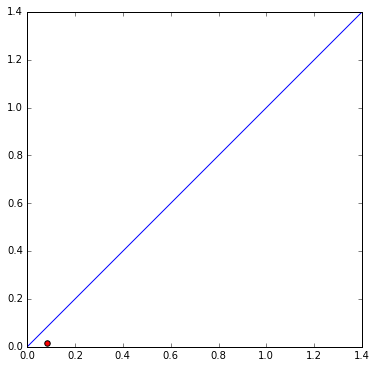

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_xlim([0,1.4]); ax.set_ylim([0,1.4])

y = Z_model/DH
x = (1.8 * ((F_RW * RL)**0.5) * (1 - (0.45 * SE)) + 0.08)

ax.plot([0, 1.4], [0,1.4])
ax.scatter(x, y, s=30, c='r')